# 导入库

In [32]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
from PyQt5 import QtCore, QtGui, QtWidgets
import datetime
import pandas
import numpy
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
# plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
from matplotlib.pylab import date2num  # 导入日期到数值一一对应的转换工具
from dateutil.parser import parse  # 导入转换到指定格式日期的工具
import mplfinance as mpf
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Lambda
from keras.layers import Dense, Activation, Dropout, GlobalMaxPool1D
from keras.layers import Flatten,Conv1D,MaxPooling1D,Conv2D
from keras.layers import GRU, Concatenate, Input, Bidirectional, BatchNormalization
from keras import regularizers,callbacks, Model
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.layers import Layer,Add
from tcn import TCN, tcn_full_summary
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor  
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.linear_model import Ridge as rd
from sklearn.linear_model import LinearRegression as lir
#评价指标
from sklearn.metrics import mean_squared_error# MSE
from sklearn.metrics import mean_absolute_error# MAE
from sklearn.metrics import r2_score
# 定义MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred.ravel() - y_true.ravel()) / y_true.ravel()))
import tensorflow as tf

# 数据读取

In [4]:
df = pd.read_excel('gujia.xlsx',index_col='Unnamed: 0')
df = df.iloc[::-1]
df = df.reset_index(drop=True)
df.trade_date = pd.to_datetime(df.trade_date,format='%Y%m%d')
df = df.set_index('trade_date')
df.rename(columns={'vol':'volume'},inplace=True)
df

,close,open,high,low,volume,amount
trade_date,,,,,,
2017-01-03,13.71,13.45,13.89,13.45,547866.09,751533.87
2017-01-04,13.99,13.72,14.13,13.70,578715.22,808480.27
2017-01-05,14.62,13.91,14.68,13.85,870474.58,1241404.70
2017-01-06,14.63,14.45,14.79,14.29,749978.15,1089705.42
2017-01-09,14.53,14.62,14.80,14.36,525471.28,762902.37
...,...,...,...,...,...,...
2023-03-14,8.72,8.83,8.87,8.65,135756.03,118722.80
2023-03-15,8.90,8.77,8.97,8.74,199628.88,176932.63
2023-03-16,8.76,8.88,8.91,8.72,143080.47,126005.93


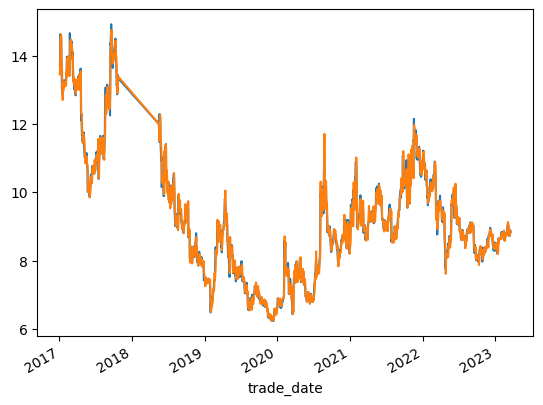

In [5]:
df.close.plot()
df.open.plot()
plt.show()

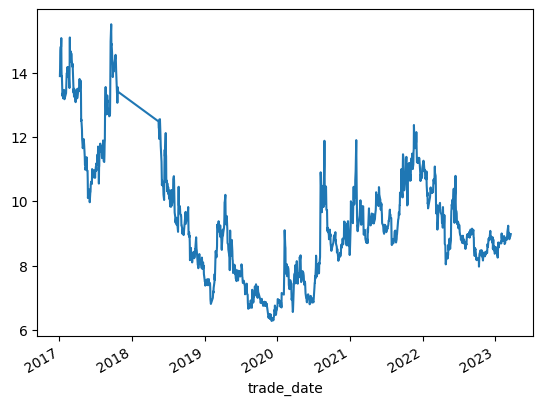

In [6]:
df.high.plot()
plt.show()

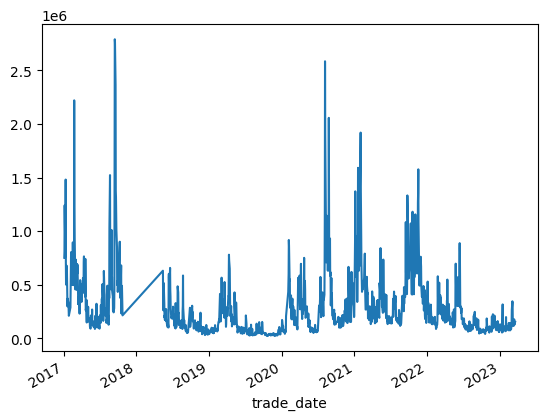

In [7]:
df.amount.plot()
plt.show()

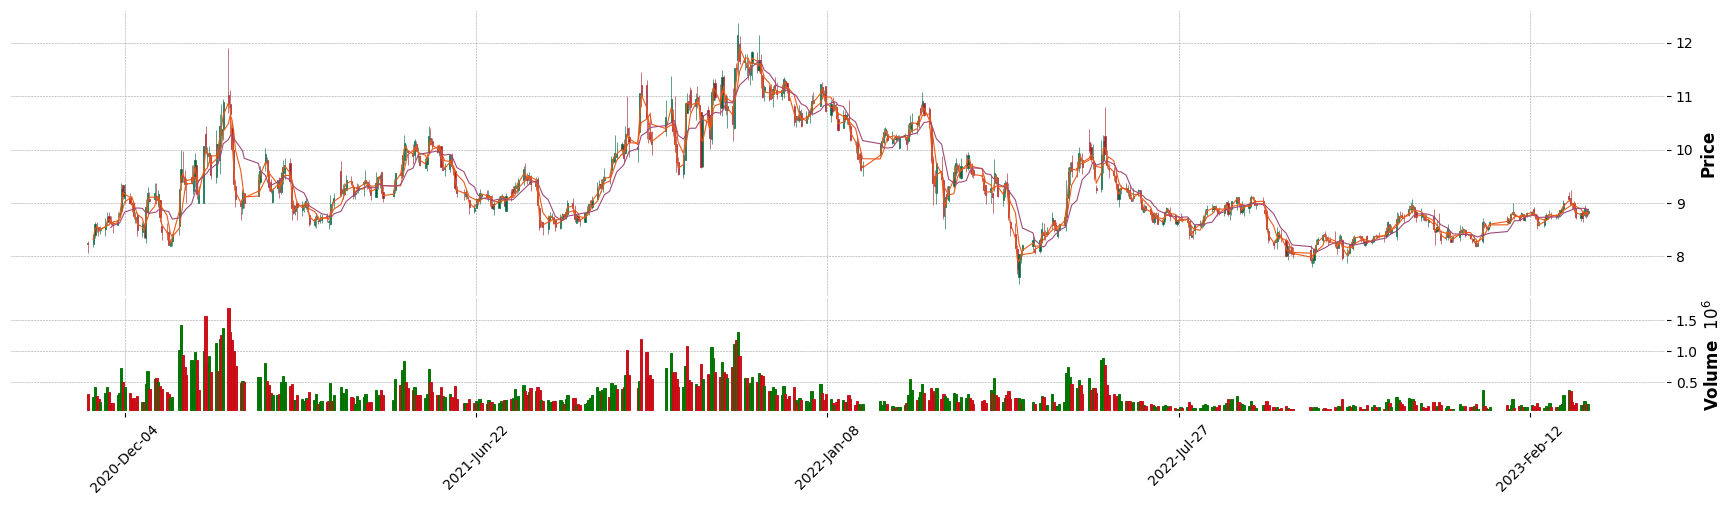

In [8]:
mpf.plot(df[800:-1], type='candle',style='charles', figratio=(60, 15) , mav=(2, 5, 10), volume=True, show_nontrading=True)

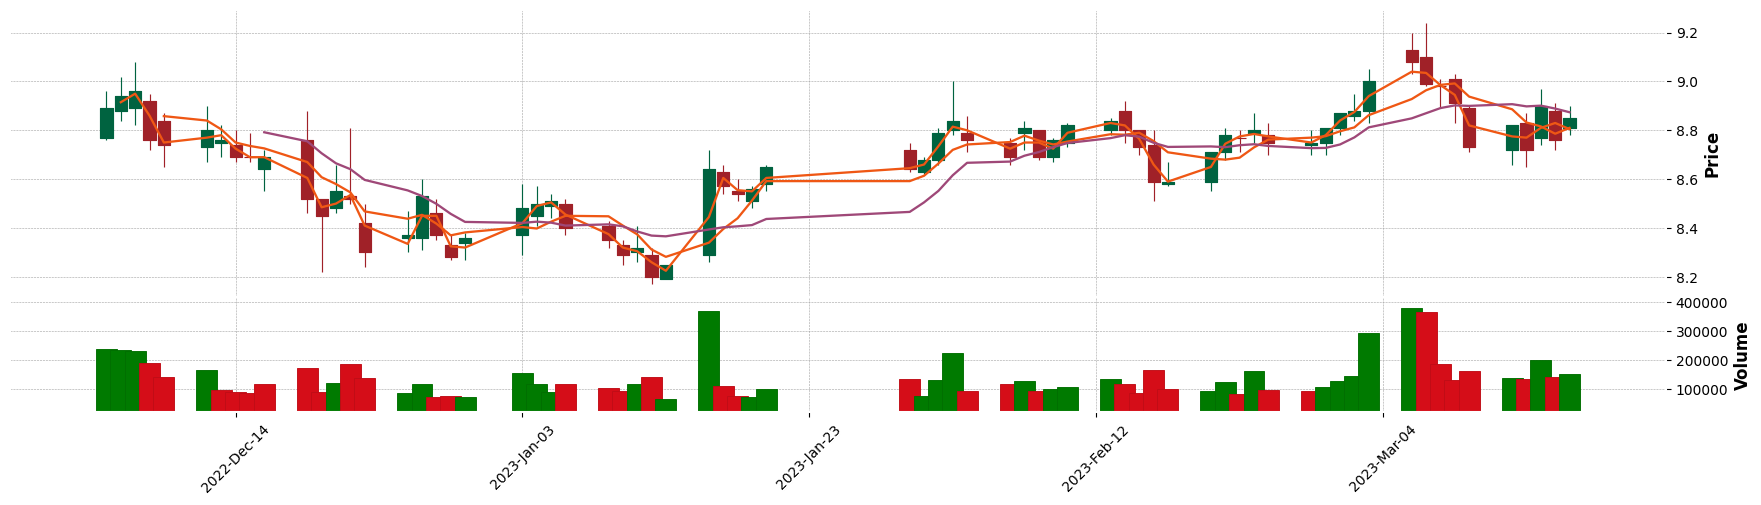

In [9]:
mpf.plot(df[1300:-1], type='candle',style='charles', figratio=(60, 15) , mav=(2, 5, 10), volume=True,show_nontrading=True)

In [10]:
close = df.close
high = df.high
low = df.low
open_ = df.open
vol = df.volume
amount = df.amount

In [11]:
df

,close,open,high,low,volume,amount
trade_date,,,,,,
2017-01-03,13.71,13.45,13.89,13.45,547866.09,751533.87
2017-01-04,13.99,13.72,14.13,13.70,578715.22,808480.27
2017-01-05,14.62,13.91,14.68,13.85,870474.58,1241404.70
2017-01-06,14.63,14.45,14.79,14.29,749978.15,1089705.42
2017-01-09,14.53,14.62,14.80,14.36,525471.28,762902.37
...,...,...,...,...,...,...
2023-03-14,8.72,8.83,8.87,8.65,135756.03,118722.80
2023-03-15,8.90,8.77,8.97,8.74,199628.88,176932.63
2023-03-16,8.76,8.88,8.91,8.72,143080.47,126005.93


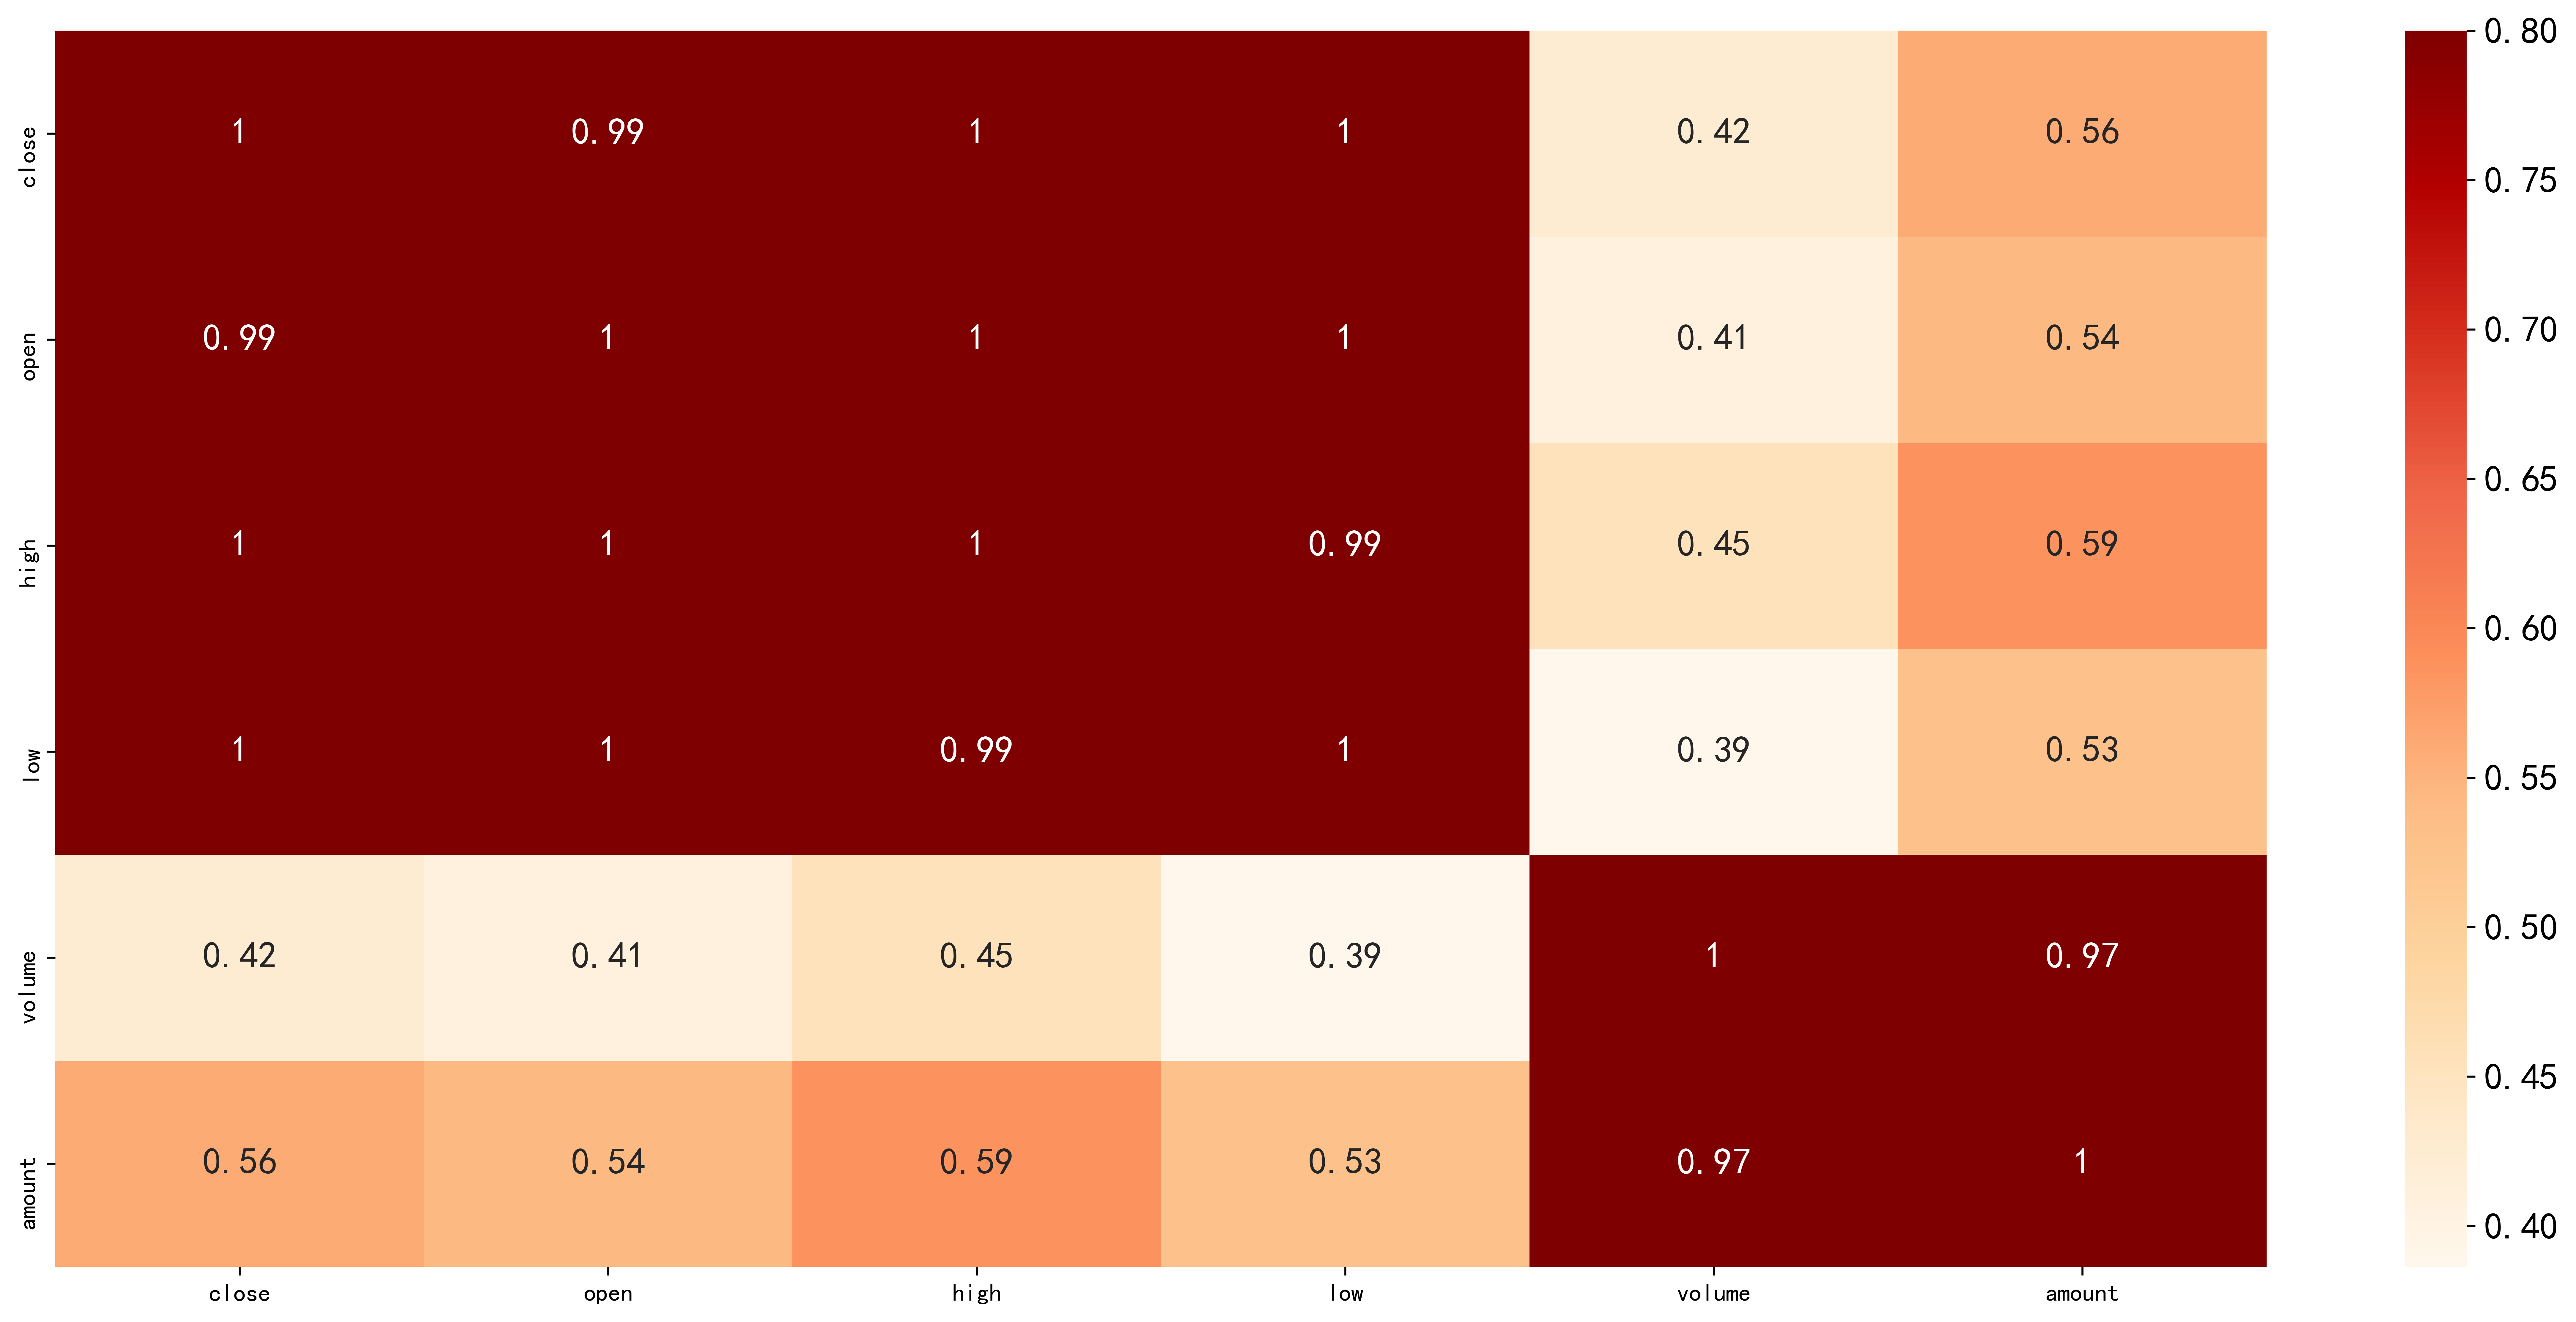

In [12]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
corrmat = df.corr('pearson')#相关性矩阵
f, ax = plt.subplots(figsize=(20, 9),dpi=600)
h = sns.heatmap(corrmat, vmax=.8, annot=True,cmap='OrRd', annot_kws={'size':15},cbar=False)
cb=h.figure.colorbar(h.collections[0])
cb.ax.tick_params(labelsize=15) 
cb.outline.set_visible(False)
#plt.savefig('相关性分析.png',dpi=600, bbox_inches='tight')
plt.show()

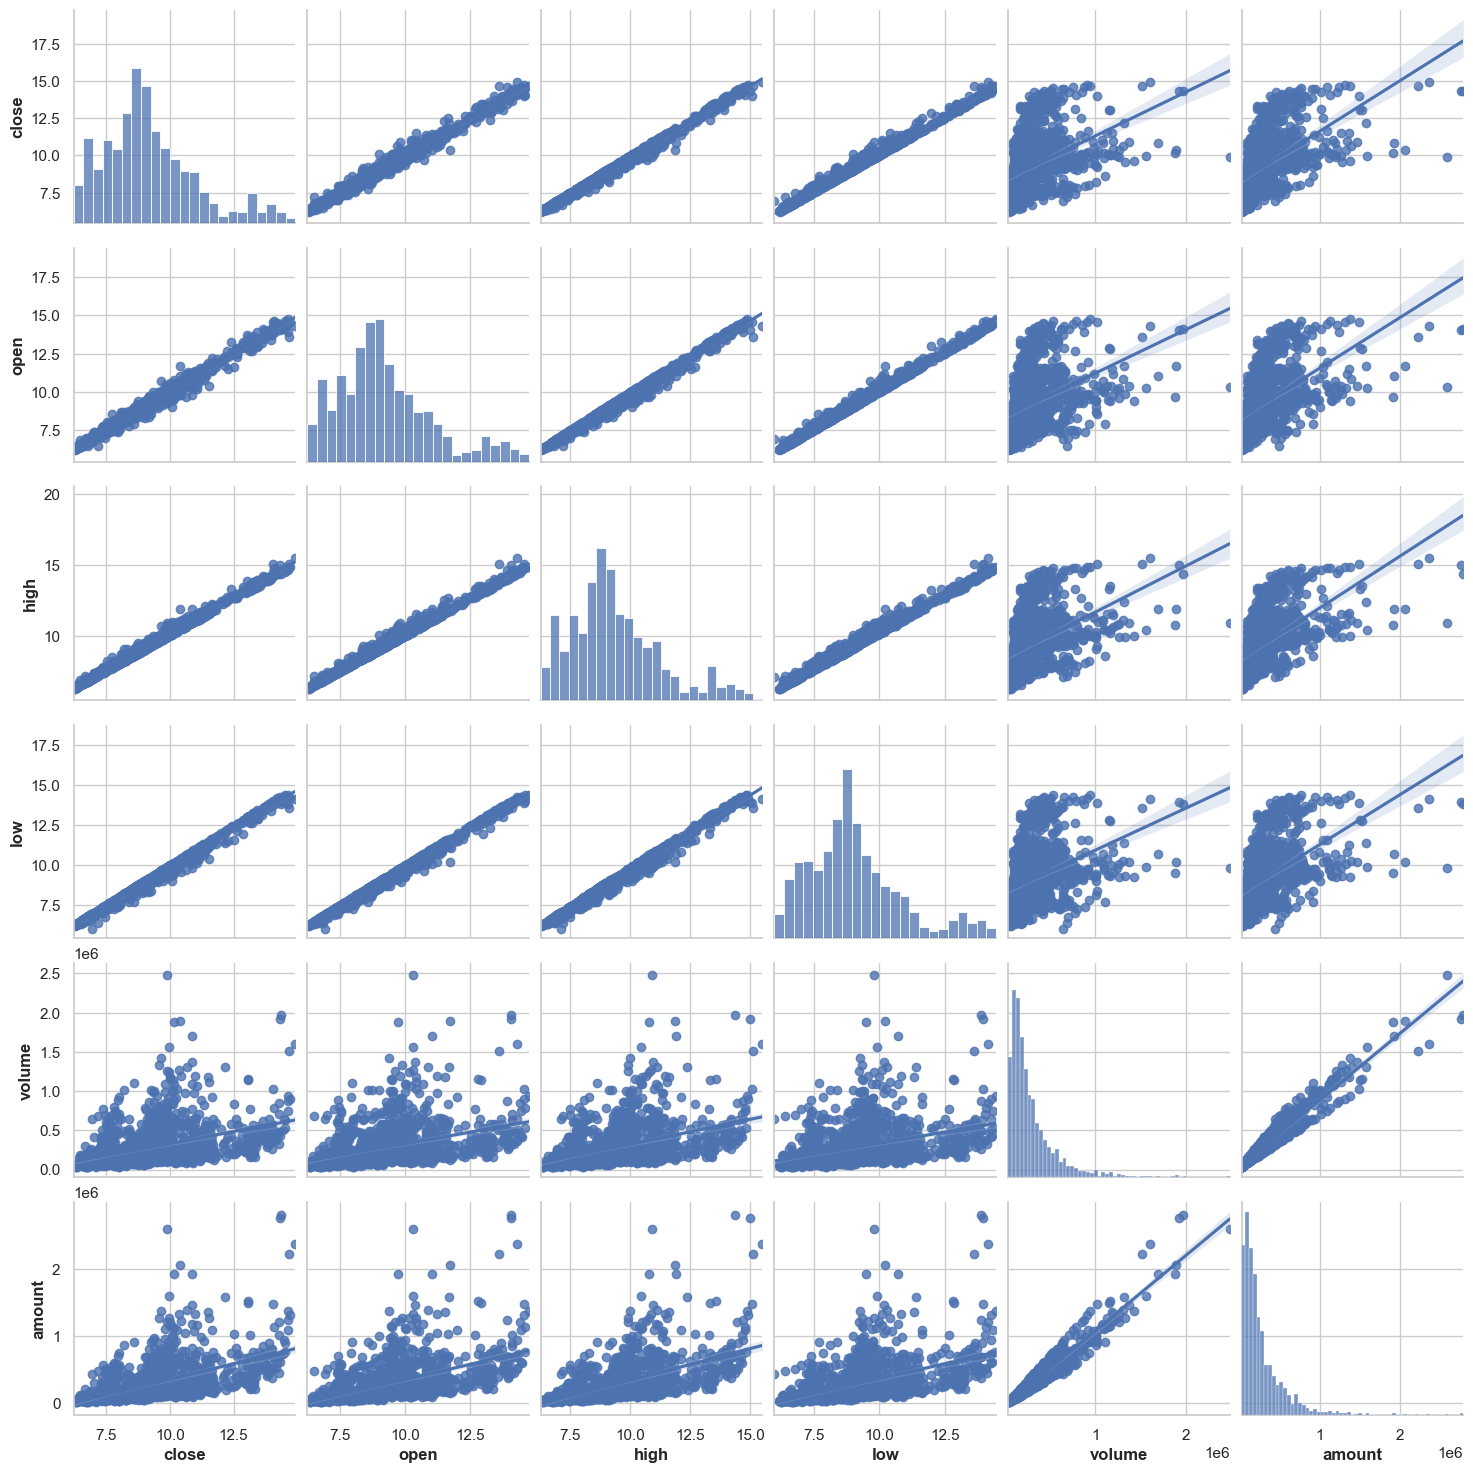

In [161]:
sns.pairplot(df[df.columns], height = 2.5,kind='reg')
plt.savefig('变量相关性.png',dpi=600, bbox_inches='tight')
plt.show()

# 数据标准化

In [13]:
def stand(df):
    df_s = StandardScaler()
    df_value = df_s.fit_transform(df)
    return df_value,df_s

In [14]:
close_value, close_s = stand(df.close.values.reshape(-1,1))
high_value, high_s = stand(df.high.values.reshape(-1,1))
low_value, low_s = stand(df.low.values.reshape(-1,1))
open__value, open__s = stand(df.open.values.reshape(-1,1))
vol_value, vol_s = stand(df.volume.values.reshape(-1,1))
amount_value, amount_s = stand(df.amount.values.reshape(-1,1))

# 时序窗口数据划分

In [15]:
x = np.concatenate([close_value,high_value,low_value,open__value,vol_value,amount_value],axis=1)
y = close.values
x.shape

(1370, 6)

In [16]:
look_back = 28
step = 7

In [17]:
def create_data(x,y):
    data_num = x.shape[0]
    x_init = []
    y_init = []
    for i in range(data_num//(look_back+step)):
        x_init.append(x[i*(look_back+step):(i+1)*look_back+i*step])
        y_init.append(y[(i+1)*look_back+i*step:(i+1)*(look_back+step)])
    x_init = np.array(x_init)
    y_init = np.array(y_init)
    return x_init,y_init

In [18]:
def xy(x,y):
    x, y = create_data(x,y)
    x_train, y_train, x_test, y_test = train_test_split(x, y, test_size=0.2, random_state=2,shuffle=True) 
    return x_train, y_train, x_test, y_test

# 定义LSTM模型

In [19]:
loss = 'mae'
metrics = 'mse'
val_metrics = 'val_'+ metrics

In [20]:
def model_lstm(x_shape,y_shape):
    model = Sequential()
    model.add(Dense(64,input_shape=(x_shape)))
    model.add(Activation('relu'))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Flatten())
    #model.add(LSTM(64, return_sequences=False))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(y_shape,name='last_layer'))
    return model

In [21]:
def train_model(x_train, y_train, x_test, y_test):
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],-1)
    x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],-1)
    model = model_lstm(x_train.shape[1:],y_train.shape[1])
    model.summary()
    optimizer = tf.keras.optimizers.Adam(lr=4e-4, amsgrad=True)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    callback = [callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=5,
        factor=0.1)]
    history = model.fit(x_train, y_train, batch_size=10,
                        epochs=100,validation_data=(x_test, y_test),
                        callbacks=callback)
    return model, history

# 训练lstm模型——close价格

In [23]:
x_train1, x_test1, y_train1, y_test1 = xy(x,y)
model_1, history_1 = train_model(x_train1, y_train1, x_test1, y_test1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 28, 64)            448       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 28, 512)           657408    
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1835136   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
last_layer (Dense)           (None, 7)                

Epoch 54/100
4/4 [==============================] - 0s 22ms/step - loss: 0.4564 - mse: 0.4047 - val_loss: 0.6284 - val_mse: 0.6620
Epoch 55/100
4/4 [==============================] - 0s 24ms/step - loss: 0.4564 - mse: 0.4047 - val_loss: 0.6285 - val_mse: 0.6622
Epoch 56/100
4/4 [==============================] - 0s 24ms/step - loss: 0.4563 - mse: 0.4047 - val_loss: 0.6280 - val_mse: 0.6616
Epoch 57/100
4/4 [==============================] - 0s 24ms/step - loss: 0.4562 - mse: 0.4047 - val_loss: 0.6278 - val_mse: 0.6614
Epoch 58/100
4/4 [==============================] - 0s 21ms/step - loss: 0.4561 - mse: 0.4046 - val_loss: 0.6277 - val_mse: 0.6613
Epoch 59/100
4/4 [==============================] - 0s 19ms/step - loss: 0.4561 - mse: 0.4046 - val_loss: 0.6277 - val_mse: 0.6613
Epoch 60/100
4/4 [==============================] - 0s 20ms/step - loss: 0.4561 - mse: 0.4046 - val_loss: 0.6277 - val_mse: 0.6613
Epoch 61/100
4/4 [==============================] - 0s 18ms/step - loss: 0.4561 - m

In [154]:
model_1.save('lstm_多变量模型权重.h5')

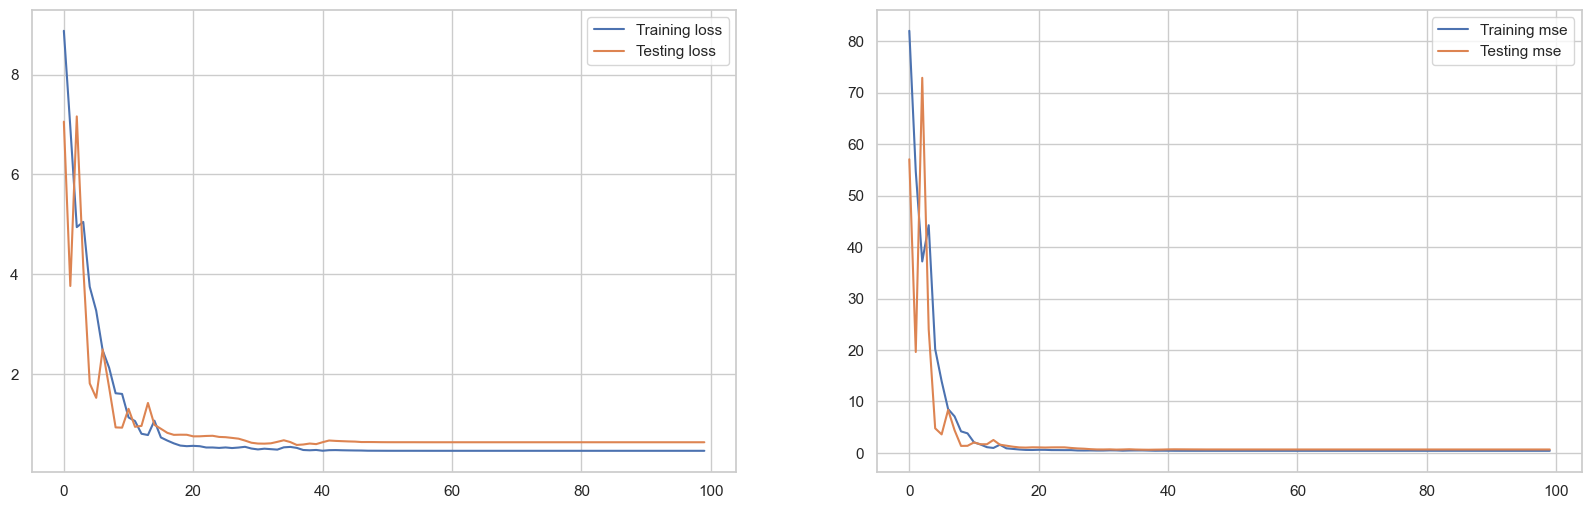

In [24]:
epochs = range(len(history_1.history['loss']))
sns.set(style='whitegrid')
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.plot(epochs, history_1.history['loss'], label='Training loss')
plt.plot(epochs, history_1.history['val_loss'], label='Testing loss')
#plt.title('Training and Testing Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, history_1.history[metrics], label='Training '+metrics)
plt.plot(epochs, history_1.history[val_metrics], label='Testing '+metrics)
#plt.title('Training and Testing '+metrics)
plt.legend()
plt.savefig("lstm.png",dpi=600, bbox_inches='tight')
plt.show()

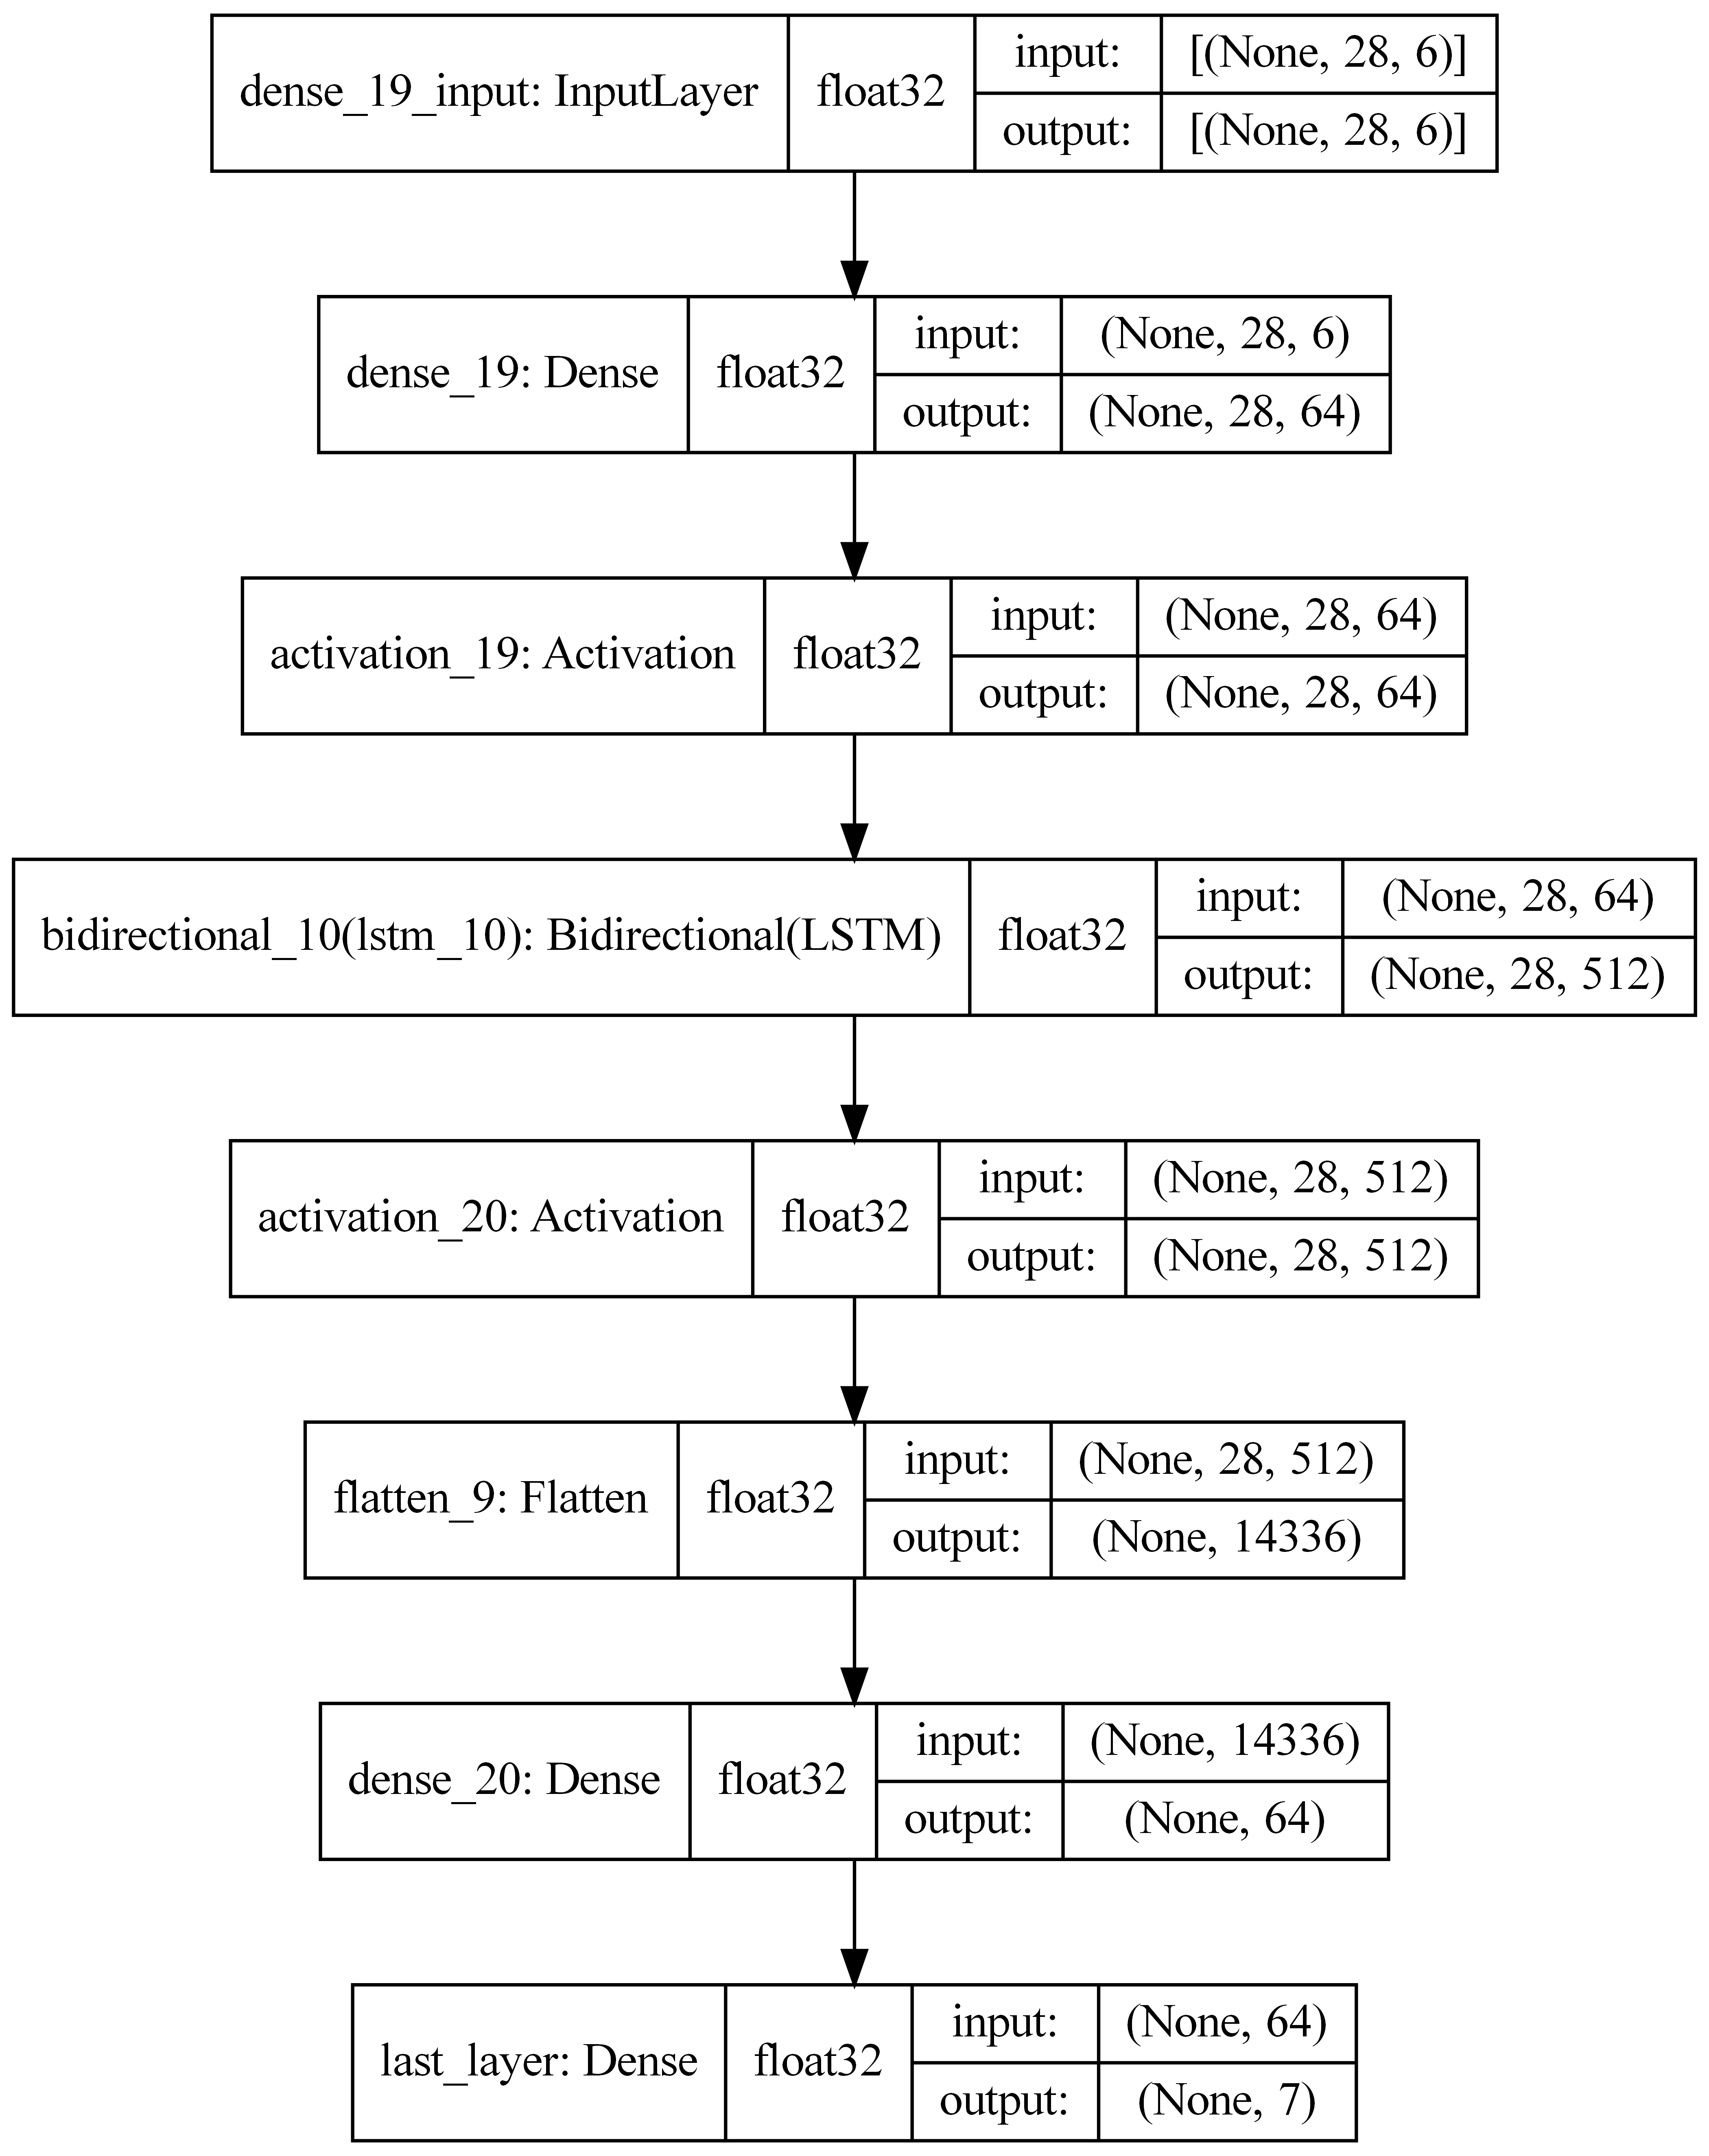

In [87]:
plot_model(model_1,to_file='close_lstm_model.png',dpi=600,show_shapes=True,show_dtype=True,expand_nested=True,rankdir='TB')

# 尾部最后一层接支持向量回归作为最后一层输出

## close data

In [38]:
model1_out = Model(inputs=model_1.input,outputs=model_1.get_layer('last_layer').output)
x_train_svr = model1_out.predict(x_train1)
x_test_svr = model1_out.predict(x_test1)
svr = MultiOutputRegressor(svm.SVR(kernel='linear',C=3,degree=3))
svr.fit(x_train_svr,y_train1)
print('lstm+svm testing r2:')
print(svr.score(x_test_svr, y_test1))

lstm+svm testing r2:
0.9174920522060884


In [26]:
svr1 = MultiOutputRegressor(svm.SVR(kernel='linear',C=3,degree=3))
svr1.fit(x_train1.reshape(x_train1.shape[0],-1),y_train1)
print('svm testing r2:')
print(svr1.score(x_test1.reshape(x_test1.shape[0],-1), y_test1))

svm testing r2:
0.8767776393179754


In [33]:
rf1 = MultiOutputRegressor(rf())
rf1.fit(x_train1.reshape(x_train1.shape[0],-1),y_train1)
print('rf testing r2:')
print(rf1.score(x_test1.reshape(x_test1.shape[0],-1), y_test1))

rf testing r2:
0.9046465670949007


In [35]:
knn1 = MultiOutputRegressor(knn())
knn1.fit(x_train1.reshape(x_train1.shape[0],-1),y_train1)
print('knn testing r2:')
print(knn1.score(x_test1.reshape(x_test1.shape[0],-1), y_test1))

knn testing r2:
0.8067337719353146


In [36]:
rd1 = MultiOutputRegressor(rd())
rd1.fit(x_train1.reshape(x_train1.shape[0],-1),y_train1)
print('ridge testing r2:')
print(rd1.score(x_test1.reshape(x_test1.shape[0],-1), y_test1))

ridge testing r2:
0.9265818404159996


In [37]:
lir1 = MultiOutputRegressor(lir())
lir1.fit(x_train1.reshape(x_train1.shape[0],-1),y_train1)
print('linear testing r2:')
print(lir1.score(x_test1.reshape(x_test1.shape[0],-1), y_test1))

linear testing r2:
0.8329738143050128


# 指标数据

In [55]:
def zhibiao(modelname,y,y_pred):
    zb = []
    print(modelname+'rmse:', np.sqrt(mean_squared_error(y, y_pred)))
    zb.append(np.sqrt(mean_squared_error(y, y_pred)))
    print(modelname+'mape:', mape(y, y_pred))
    zb.append(mape(y, y_pred))
    print(modelname+'MAE:', mean_absolute_error(y, y_pred))
    zb.append(mean_absolute_error(y, y_pred))
    print(modelname+'MSE:', mean_squared_error(y, y_pred))
    zb.append(mean_squared_error(y, y_pred))
    print(modelname+'r2:', r2_score(y, y_pred))
    zb.append(r2_score(y, y_pred))
    return zb

## close data

In [56]:
zb_lstm_svr = zhibiao('lstm+svm for close data ',y_test1,svr.predict(x_test_svr))

lstm+svm for close data rmse: 0.7104747888014463
lstm+svm for close data mape: 0.056767018744967146
lstm+svm for close data MAE: 0.5485445764930373
lstm+svm for close data MSE: 0.5047744255224598
lstm+svm for close data r2: 0.9174920522060884


In [57]:
zb_lstm = zhibiao('lstm for close data ',y_test1,x_test_svr)

lstm for close data rmse: 0.8132150111956465
lstm for close data mape: 0.06490980990168087
lstm for close data MAE: 0.6277469512394497
lstm for close data MSE: 0.6613186544339354
lstm for close data r2: 0.8921173655064997


In [58]:
zb_svr = zhibiao('svr for close data ',y_test1,svr1.predict(x_test1.reshape(x_test1.shape[0],-1)))

svr for close data rmse: 0.8757627585068993
svr for close data mape: 0.0699444532850487
svr for close data MAE: 0.6619360739055697
svr for close data MSE: 0.7669604091876137
svr for close data r2: 0.8767776393179754


In [59]:
zb_rf = zhibiao('rf for close data ',y_test1,rf1.predict(x_test1.reshape(x_test1.shape[0],-1)))

rf for close data rmse: 0.7677779732774334
rf for close data mape: 0.06560684924049373
rf for close data MAE: 0.6085875000000007
rf for close data MSE: 0.5894830162500032
rf for close data r2: 0.9046465670949007


In [60]:
zb_knn = zhibiao('knn for close data ',y_test1,knn1.predict(x_test1.reshape(x_test1.shape[0],-1)))

knn for close data rmse: 1.0964652948712708
knn for close data mape: 0.09093052846175713
knn for close data MAE: 0.8695714285714286
knn for close data MSE: 1.2022361428571426
knn for close data r2: 0.8067337719353146


In [61]:
zb_lr = zhibiao('linear for close data ',y_test1,lir1.predict(x_test1.reshape(x_test1.shape[0],-1)))

linear for close data rmse: 1.021312758160315
linear for close data mape: 0.08681267578429738
linear for close data MAE: 0.8098901423022397
linear for close data MSE: 1.04307974998103
linear for close data r2: 0.8329738143050128


In [116]:
zb_dicts = {'LSTM_SVR':np.array(zb_lstm_svr),'LSTM':np.array(zb_lstm),'SVR':np.array(zb_svr),'RF':np.array(zb_rf),'KNN':np.array(zb_knn),'LR':np.array(zb_lr)}
cp = pd.DataFrame(zb_dicts,index=['RMSE','MAPE','MAE','MSE','R2'])
cp

,LSTM_SVR,LSTM,SVR,RF,KNN,LR
RMSE,0.710475,0.813215,0.875763,0.767778,1.096465,1.021313
MAPE,0.056767,0.064910,0.069944,0.065607,0.090931,0.086813
MAE,0.548545,0.627747,0.661936,0.608588,0.869571,0.809890
MSE,0.504774,0.661319,0.766960,0.589483,1.202236,1.043080
R2,0.917492,0.892117,0.876778,0.904647,0.806734,0.832974


In [117]:
cp = cp.stack()

In [118]:
cp

RMSE  LSTM_SVR    0.710475
      LSTM        0.813215
      SVR         0.875763
      RF          0.767778
      KNN         1.096465
      LR          1.021313
MAPE  LSTM_SVR    0.056767
      LSTM        0.064910
      SVR         0.069944
      RF          0.065607
      KNN         0.090931
      LR          0.086813
MAE   LSTM_SVR    0.548545
      LSTM        0.627747
      SVR         0.661936
      RF          0.608588
      KNN         0.869571
      LR          0.809890
MSE   LSTM_SVR    0.504774
      LSTM        0.661319
      SVR         0.766960
      RF          0.589483
      KNN         1.202236
      LR          1.043080
R2    LSTM_SVR    0.917492
      LSTM        0.892117
      SVR         0.876778
      RF          0.904647
      KNN         0.806734
      LR          0.832974
dtype: float64

In [119]:
cp = cp.reset_index()
cp = cp.rename(columns={0:'score'})
cp = cp.rename(columns={'level_1':'models'})

# 指标对比

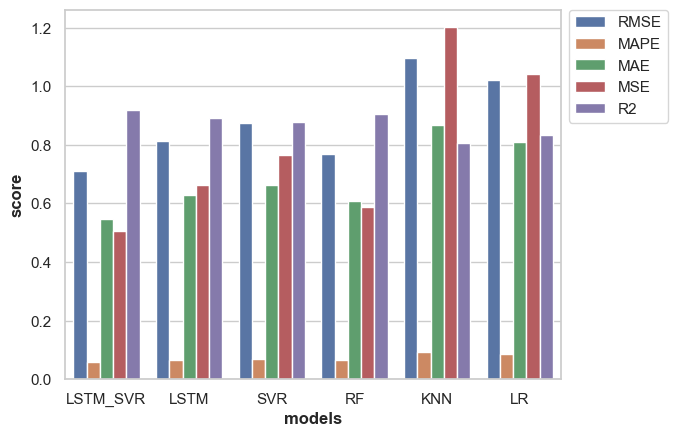

In [122]:
ax = sns.barplot(x=cp['models'], 
        y=cp['score'], 
        hue=cp['level_0'], 
        data=cp)
l = ax.legend(loc=2,bbox_to_anchor=(1, 1.02))#,ncol =12
l.set_title('')
plt.savefig('模型指标对比.png',dpi=600, bbox_inches='tight')
plt.show()

# close数据还原绘图对比

In [45]:
def inv_stand(df_value,df_s):
    df_true = df_s.inverse_transform(df_value)
    return df_true

In [123]:
y_close_pred_lstm_svm = inv_stand(svr.predict(x_test_svr),close_s)
y_close_pred_lstm = inv_stand(model_1.predict(x_test1),close_s)
y_close_pred_svr = inv_stand(svr1.predict(x_test1.reshape(x_test1.shape[0],-1)),close_s)
y_close_pred_rf = inv_stand(rf1.predict(x_test1.reshape(x_test1.shape[0],-1)),close_s)
y_close_pred_knn = inv_stand(knn1.predict(x_test1.reshape(x_test1.shape[0],-1)),close_s)
y_close_pred_lr = inv_stand(lir1.predict(x_test1.reshape(x_test1.shape[0],-1)),close_s)
y_true = inv_stand(y_test1,close_s)

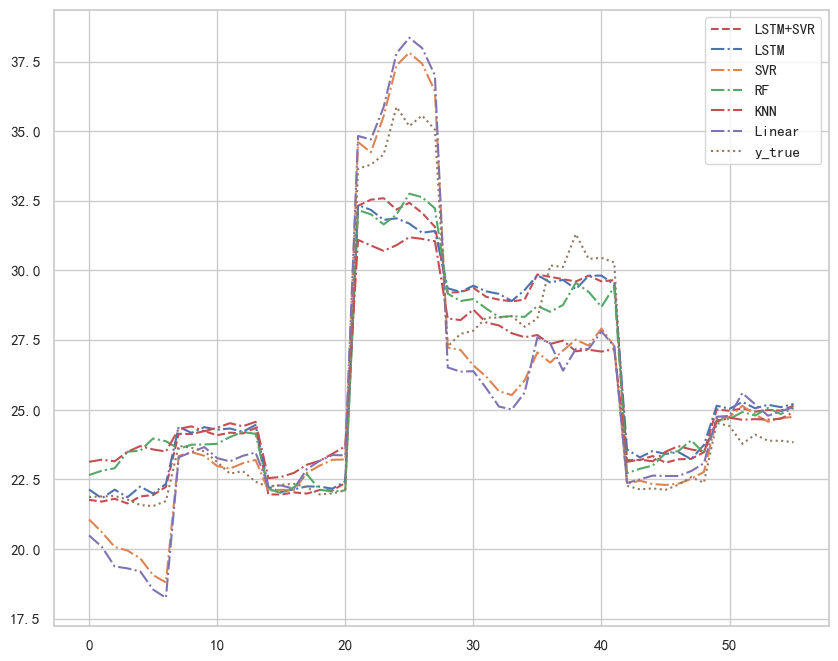

In [124]:
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(10,8))
plt.plot(range(len(y_test1.ravel())),y_close_pred_lstm_svm.ravel(),ls='--',color='r',label='LSTM+SVR')
plt.plot(range(len(y_test1.ravel())),y_close_pred_lstm.ravel(),ls='-.',label='LSTM')
plt.plot(range(len(y_test1.ravel())),y_close_pred_svr.ravel(),ls='-.',label='SVR')
plt.plot(range(len(y_test1.ravel())),y_close_pred_rf.ravel(),ls='-.',label='RF')
plt.plot(range(len(y_test1.ravel())),y_close_pred_knn.ravel(),ls='-.',label='KNN')
plt.plot(range(len(y_test1.ravel())),y_close_pred_lr.ravel(),ls='-.',label='Linear')
plt.plot(range(len(y_test1.ravel())),y_true.ravel(),ls=':',label='y_true')
#plt.title('模型预测效果对比')
plt.legend()
plt.savefig('模型预测效果对比.png',dpi=600, bbox_inches='tight')
plt.show()

# 数据导出

In [127]:
dicts = {'lstm_svm':y_close_pred_lstm_svm.ravel(),'lstm':y_close_pred_lstm.ravel(),'svr':y_close_pred_svr.ravel(),'rf':y_close_pred_rf.ravel(),'knn':y_close_pred_knn.ravel(),'linear':y_close_pred_lr.ravel(), 'y_true':y_true.ravel()}
d = pd.DataFrame(dicts,index=range(y_true.ravel().shape[0]))
d

,lstm_svm,lstm,svr,rf,knn,linear,y_true
0,21.766145,22.138277,21.063134,22.657326,23.132635,20.490850,21.870720
1,21.704857,21.822710,20.608867,22.812429,23.209005,20.081024,21.888903
2,21.806713,22.132570,20.075728,22.901890,23.150819,19.377461,21.907086
3,21.637302,21.862295,19.948160,23.493936,23.492663,19.307600,21.779804
4,21.889997,22.242702,19.665254,23.531757,23.696315,19.196879,21.579788
5,21.939071,21.993845,19.064584,23.969791,23.576306,18.546614,21.543422
6,22.231720,22.338518,18.801294,23.870511,23.499937,18.251252,21.725254
7,24.137603,24.386715,23.342541,23.600308,24.314545,23.294898,23.707225
8,24.129088,24.171797,23.479593,23.748319,24.405461,23.481035,23.634492
9,24.233363,24.377104,23.349006,23.753956,24.230902,23.661445,23.507210


In [128]:
d.to_excel('多变量一周预测的数据.xls')

<ipython-input-128-6ef554220737>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  d.to_excel('多变量一周预测的数据.xls')
